# **Lunar Lander con Q-Learning**

### **1. Bibliotecas**

In [1]:
import sys
# Tal vez tengan que ejecutar lo siguiente en sus máquinas (ubuntu 20.04)
# sudo apt-get remove swig
# sudo apt-get install swig3.0
# sudo ln -s /usr/bin/swig3.0 /usr/bin/swig
# En windows tambien puede ser necesario MSVC++
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random

### **2. Jugando a mano**

A continuación se puede jugar un episodio del lunar lander. Se controlan los motores con el teclado. Notar que solo se puede realizar una acción a la vez (que es parte del problema), y que en esta implementación, izq toma precedencia sobre derecha, que toma precedencia sobre el motor principal.

In [2]:
# Nota: hay que transformar esta celda en código para ejecutar (Esc + y)

import pygame
from pygame.locals import *

# Inicializar pygame (para el control con el teclado) y el ambiente
pygame.init()
env = gym.make('LunarLander-v2', render_mode='human')
env.reset()
pygame.display.set_caption('Lunar Lander')

clock = pygame.time.Clock()
done = False

while not done:
    for event in pygame.event.get():
        if event.type == QUIT:
            done = True
            break

    keys = pygame.key.get_pressed()

    # Map keys to actions
    if keys[K_LEFT]:
        action = 3  # Fire left orientation engine
    elif keys[K_RIGHT]:
        action = 1 # Fire right orientation engine
    elif keys[K_UP]:
        action = 2  # Fire main engine
    else:
        action = 0  # Do nothing

    _, _, terminated, truncated, _ = env.step(action)
    env.render()
    clock.tick(10)

    if terminated or truncated:
        done = True

env.close()
pygame.quit()

## **3. Discretizando el estado**

El estado consiste de posiciones y velocidades en (x,y,theta) y en información de contacto de los pies con la superficie.

Como varios de estos son continuos, tenemos que discretizarlos para aplicar nuestro algoritmo de aprendizaje por refuerzo tabular.

In [ ]:
# Cuántos bins queremos por dimensión
# Pueden considerar variar este parámetro
bins_per_dim = 15

# Estado:
# (x, y, x_vel, y_vel, theta, theta_vel, pie_izq_en_contacto, pie_derecho_en_contacto)
NUM_BINS = [bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, 2, 2]

env = gym.make('LunarLander-v2')
env.reset()

# Tomamos los rangos del env
OBS_SPACE_HIGH = env.observation_space.high
OBS_SPACE_LOW = env.observation_space.low
OBS_SPACE_LOW[1] = 0 # Para la coordenada y (altura), no podemos ir más abajo que la zona dea aterrizae (que está en el 0, 0)

# Los bins para cada dimensión
bins = [
    np.linspace(OBS_SPACE_LOW[i], OBS_SPACE_HIGH[i], NUM_BINS[i] - 1)
    for i in range(len(NUM_BINS) - 2) # last two are binary
]
# Se recomienda observar los bins para entender su estructura
#print ("Bins: ", bins)
def discretize_state(state, bins):
    """Discretize the continuous state into a tuple of discrete indices."""
    state_disc = list()
    for i in range(len(state)):
        if i >= len(bins):  # For binary features (leg contacts)
            state_disc.append(int(state[i]))
        else:
            state_disc.append(
                np.digitize(state[i], bins[i])
            )
    return tuple(state_disc)

In [ ]:
# Ejemplos
print(discretize_state([0.0, 0.0, 0, 0, 0, 0, 1, 1], bins)) # En la zona de aterrizaje y quieto
print(discretize_state([0, 1.5, 0, 0, 0, 0, 0, 0], bins)) # Comenzando la partida, arriba y en el centro

(np.int64(7), np.int64(1), np.int64(7), np.int64(7), np.int64(7), np.int64(7), 1, 1)
(np.int64(7), np.int64(14), np.int64(7), np.int64(7), np.int64(7), np.int64(7), 0, 0)


## **4. Agentes y la interacción con el entorno**

Vamos a definir una interfaz para nuestro agente:

In [5]:
class Agente:
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        """Elegir la accion a tomar en el estado actual y el espacio de acciones
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó
        """
        pass

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        """Aprender a partir de la tupla 
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó en esta transición
        """
        pass

    def fin_episodio(self):
        """Actualizar estructuras al final de un episodio"""
        pass

Para un agente aleatorio, la implementación sería:

In [6]:
import random

class AgenteAleatorio(Agente):
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        # Elige una acción al azar
        return random.randrange(max_accion)

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        # No aprende
        pass

    def fin_episodio(self):
        # Nada que actualizar
        pass

Luego podemos definir una función para ejecutar un episodio con un agente dado:

#### Función para ejecutar episodio en entrenamiento

In [7]:
def ejecutar_episodio_1(agente, aprender = True, render = None, max_iteraciones=500):
    entorno = gym.make('LunarLander-v2', render_mode=render).env
    
    iteraciones = 0
    recompensa_total = 0

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset()
    while iteraciones < max_iteraciones and not termino and not truncado:
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n, aprender)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # Le informamos al agente para que aprenda
        if (aprender):
            agente.aprender(estado_anterior, estado_siguiente, accion, recompensa, termino)

        estado_anterior = estado_siguiente
        iteraciones += 1
        recompensa_total += recompensa
    if (aprender):
        agente.fin_episodio()
    entorno.close()
    return recompensa_total

#### Función para ejecutar episodios y guardar los entornos para poder reproducirlos a la hora del análisis

In [8]:
def ejecutar_episodio_2(agente, aprender=True, max_iteraciones=500):
    entorno = gym.make('LunarLander-v2').env
    semilla = entorno.np_random.bit_generator._seed_seq.entropy
    iteraciones = 0
    recompensa_total = 0
    episodio = []

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset(seed=semilla)
    while iteraciones < max_iteraciones and not termino and not truncado:
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n, aprender)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # Le informamos al agente para que aprenda
        if aprender:
            agente.aprender(estado_anterior, estado_siguiente, accion, recompensa, termino)

        # Almacenar el estado, acción y recompensa
        episodio.append((estado_anterior, accion, recompensa))

        estado_anterior = estado_siguiente
        iteraciones += 1
        recompensa_total += recompensa

    if aprender:
        agente.fin_episodio()
    entorno.close()
    return recompensa_total, episodio, semilla

In [9]:
# Nota: hay que transformar esta celda en código para ejecutar (Esc + y)

# Ejecutamos un episodio con el agente aleatorio y modo render 'human', para poder verlo
ejecutar_episodio_1(AgenteAleatorio(), render = 'human')

np.float64(-287.40263757335816)

Podemos ejecutar este ambiente muchas veces y tomar métricas al respecto

In [10]:
agente = AgenteAleatorio()
recompensa_episodios = []

exitos = 0
num_episodios = 100
for i in range(num_episodios):
    recompensa = ejecutar_episodio_1(agente)
    # Los episodios se consideran exitosos si se obutvo 200 o más de recompensa total
    if (recompensa >= 200):
        exitos += 1
    recompensa_episodios += [recompensa]

import numpy
print(f"Tasa de éxito: {exitos / num_episodios}. Se obtuvo {numpy.mean(recompensa_episodios)} de recompensa, en promedio")

Tasa de éxito: 0.0. Se obtuvo -179.65198126971825 de recompensa, en promedio


### **5. Programando un agente que aprende**

La tarea a realizar consiste en programar un agente de aprendizaje por refuerzos:

In [11]:
import numpy as np
import random
from collections import defaultdict
class AgenteRL(Agente):
    # Agregar código aqui

    # Pueden agregar parámetros al constructor
    def __init__(self, max_accion, bins, initial_epsilon: float, epsilon_decay: float, final_epsilon: float, discount_factor: float = 0.95):
        super().__init__()

        self.q_table = defaultdict(lambda: np.zeros(max_accion))
        self.visitas = defaultdict(lambda: np.zeros(max_accion))

        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.bins = bins
    
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:

        estado_discreto = discretize_state(estado, self.bins)
        if (explorar and np.random.random() < self.epsilon):
            return random.randrange(max_accion)
        else:
            return int(np.argmax(self.q_table[estado_discreto]))
    
    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        estado_anterior_discreto = discretize_state(estado_anterior, self.bins)
        estado_siguiente_discreto = discretize_state(estado_siguiente, self.bins)

        self.visitas[estado_anterior_discreto][accion] += 1

        future_q_value = (not terminado) * np.max(self.q_table[estado_siguiente_discreto])
        temporal_difference = (
            recompensa + self.discount_factor * future_q_value - self.q_table[estado_anterior_discreto][accion]
        )

        alpha = 1 / self.visitas[estado_anterior_discreto][accion]

        self.q_table[estado_anterior_discreto][accion] = (
            self.q_table[estado_anterior_discreto][accion] + alpha * temporal_difference
        )
    def fin_episodio(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

Y ejecutar con el muchos episodios:

In [12]:
# Nota: hay que transformar esta celda en código para ejecutar (Esc + y)
# Advertencia: este bloque es un loop infinito si el agente se deja sin implementar
from tqdm import tqdm 
entorno = gym.make('LunarLander-v2').env
num_episodios = 100000
max_accion = entorno.action_space.n
initial_epsilon = 1.0
epsilon_decay = initial_epsilon / (num_episodios / 2)
final_epsilon = 0.05
discount_factor = 0.95

agente = AgenteRL(max_accion = max_accion, bins = bins, initial_epsilon = initial_epsilon, epsilon_decay = epsilon_decay, final_epsilon = final_epsilon, discount_factor = discount_factor)
exitos = 0
recompensa_episodios = []
promedio_recompensa = []
with tqdm(total=num_episodios) as pbar:
    for i in range(num_episodios):
        recompensa = ejecutar_episodio_1(agente)
        if i % 1000 == 0:
            ultimas_1000_recompensas = recompensa_episodios[-1000:]
            promedio_ultimas_1000 = np.mean(ultimas_1000_recompensas)
            promedio_recompensa.append(promedio_ultimas_1000)
            print(f" Se obtuvo {promedio_ultimas_1000} de recompensa, en promedio en los últimos 1000 episodios")
        if (recompensa >= 200):
            exitos += 1
        recompensa_episodios += [recompensa]
        pbar.set_postfix(recompensa=recompensa, promedio=numpy.mean(recompensa_episodios))
        pbar.update(1)
print(f"Tasa de éxito: {exitos / num_episodios}. Se obtuvo {numpy.mean(recompensa_episodios)} de recompensa, en promedio")

  0%|          | 0/100000 [00:00<?, ?it/s]/home/julio/.local/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/julio/.local/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  0%|          | 9/100000 [00:00<26:52, 61.99it/s, promedio=-248, recompensa=-332] 

 Se obtuvo nan de recompensa, en promedio en los últimos 1000 episodios


  1%|          | 1013/100000 [00:16<26:09, 63.07it/s, promedio=-178, recompensa=-221] 

 Se obtuvo -178.30962215145314 de recompensa, en promedio en los últimos 1000 episodios


  2%|▏         | 2011/100000 [00:32<27:45, 58.85it/s, promedio=-178, recompensa=-387] 

 Se obtuvo -177.14323287314554 de recompensa, en promedio en los últimos 1000 episodios


  3%|▎         | 3011/100000 [00:49<25:41, 62.92it/s, promedio=-174, recompensa=-479]  

 Se obtuvo -166.63590724152357 de recompensa, en promedio en los últimos 1000 episodios


  4%|▍         | 4010/100000 [01:06<26:41, 59.93it/s, promedio=-169, recompensa=-21.1]

 Se obtuvo -156.0996278873348 de recompensa, en promedio en los últimos 1000 episodios


  5%|▌         | 5011/100000 [01:23<28:34, 55.40it/s, promedio=-166, recompensa=-195] 

 Se obtuvo -153.5853381574535 de recompensa, en promedio en los últimos 1000 episodios


  6%|▌         | 6011/100000 [01:39<27:16, 57.42it/s, promedio=-164, recompensa=-189] 

 Se obtuvo -150.40977335661918 de recompensa, en promedio en los últimos 1000 episodios


  7%|▋         | 7012/100000 [01:57<26:39, 58.15it/s, promedio=-163, recompensa=16.9] 

 Se obtuvo -157.02781958066942 de recompensa, en promedio en los últimos 1000 episodios


  8%|▊         | 8008/100000 [02:13<30:08, 50.88it/s, promedio=-161, recompensa=-178] 

 Se obtuvo -149.16058700894416 de recompensa, en promedio en los últimos 1000 episodios


  9%|▉         | 9012/100000 [02:31<25:44, 58.92it/s, promedio=-159, recompensa=-111] 

 Se obtuvo -146.51300494302993 de recompensa, en promedio en los últimos 1000 episodios


 10%|█         | 10011/100000 [02:48<25:25, 58.99it/s, promedio=-158, recompensa=-129] 

 Se obtuvo -143.32178123647273 de recompensa, en promedio en los últimos 1000 episodios


 11%|█         | 11012/100000 [03:06<26:23, 56.20it/s, promedio=-156, recompensa=-93]  

 Se obtuvo -140.31638485021008 de recompensa, en promedio en los últimos 1000 episodios


 12%|█▏        | 12011/100000 [03:24<27:28, 53.37it/s, promedio=-154, recompensa=-166]  

 Se obtuvo -135.74039565860357 de recompensa, en promedio en los últimos 1000 episodios


 13%|█▎        | 13010/100000 [03:43<27:04, 53.56it/s, promedio=-153, recompensa=-94.2]

 Se obtuvo -137.30188149479312 de recompensa, en promedio en los últimos 1000 episodios


 14%|█▍        | 14010/100000 [04:02<26:01, 55.06it/s, promedio=-152, recompensa=-14]   

 Se obtuvo -135.49286414232364 de recompensa, en promedio en los últimos 1000 episodios


 15%|█▌        | 15011/100000 [04:21<26:09, 54.15it/s, promedio=-151, recompensa=-32.6]

 Se obtuvo -140.08643124734877 de recompensa, en promedio en los últimos 1000 episodios


 16%|█▌        | 16009/100000 [04:41<29:06, 48.08it/s, promedio=-150, recompensa=-221] 

 Se obtuvo -132.53071696733386 de recompensa, en promedio en los últimos 1000 episodios


 17%|█▋        | 17010/100000 [05:02<27:08, 50.96it/s, promedio=-149, recompensa=-82.9] 

 Se obtuvo -137.19108100593633 de recompensa, en promedio en los últimos 1000 episodios


 18%|█▊        | 18008/100000 [05:24<29:48, 45.85it/s, promedio=-148, recompensa=-133]   

 Se obtuvo -131.37739460247 de recompensa, en promedio en los últimos 1000 episodios


 19%|█▉        | 19011/100000 [05:46<29:09, 46.30it/s, promedio=-147, recompensa=-229]   

 Se obtuvo -128.46887439789867 de recompensa, en promedio en los últimos 1000 episodios


 20%|██        | 20009/100000 [06:07<28:27, 46.84it/s, promedio=-146, recompensa=-61.2] 

 Se obtuvo -121.71547971191798 de recompensa, en promedio en los últimos 1000 episodios


 21%|██        | 21010/100000 [06:31<29:20, 44.87it/s, promedio=-144, recompensa=-25.6] 

 Se obtuvo -113.4655534435826 de recompensa, en promedio en los últimos 1000 episodios


 22%|██▏       | 22008/100000 [06:55<28:22, 45.81it/s, promedio=-143, recompensa=-130]   

 Se obtuvo -111.14026376048139 de recompensa, en promedio en los últimos 1000 episodios


 23%|██▎       | 23008/100000 [07:20<31:21, 40.91it/s, promedio=-141, recompensa=-131]  

 Se obtuvo -107.27149117879766 de recompensa, en promedio en los últimos 1000 episodios


 24%|██▍       | 24007/100000 [07:46<33:57, 37.30it/s, promedio=-140, recompensa=-121]  

 Se obtuvo -110.05343784924872 de recompensa, en promedio en los últimos 1000 episodios


 25%|██▌       | 25008/100000 [08:12<34:01, 36.73it/s, promedio=-139, recompensa=-51.8] 

 Se obtuvo -105.77891106449705 de recompensa, en promedio en los últimos 1000 episodios


 26%|██▌       | 26009/100000 [08:40<30:21, 40.62it/s, promedio=-137, recompensa=3.39]   

 Se obtuvo -100.02385759035646 de recompensa, en promedio en los últimos 1000 episodios


 27%|██▋       | 27006/100000 [09:08<36:08, 33.66it/s, promedio=-136, recompensa=-120]  

 Se obtuvo -103.30193406936641 de recompensa, en promedio en los últimos 1000 episodios


 28%|██▊       | 28008/100000 [09:37<32:40, 36.71it/s, promedio=-135, recompensa=-74.1] 

 Se obtuvo -102.81607474033586 de recompensa, en promedio en los últimos 1000 episodios


 29%|██▉       | 29005/100000 [10:07<41:56, 28.21it/s, promedio=-133, recompensa=-194]  

 Se obtuvo -98.01344443975684 de recompensa, en promedio en los últimos 1000 episodios


 30%|███       | 30005/100000 [10:37<32:12, 36.21it/s, promedio=-132, recompensa=-185]   

 Se obtuvo -99.35332268997865 de recompensa, en promedio en los últimos 1000 episodios


 31%|███       | 31006/100000 [11:07<33:32, 34.28it/s, promedio=-131, recompensa=-72.7] 

 Se obtuvo -99.03522713612155 de recompensa, en promedio en los últimos 1000 episodios


 32%|███▏      | 32005/100000 [11:40<39:14, 28.87it/s, promedio=-130, recompensa=-121]  

 Se obtuvo -106.19527616506349 de recompensa, en promedio en los últimos 1000 episodios


 33%|███▎      | 33005/100000 [12:14<34:14, 32.61it/s, promedio=-130, recompensa=-259] 

 Se obtuvo -107.32993237159262 de recompensa, en promedio en los últimos 1000 episodios


 34%|███▍      | 34008/100000 [12:48<30:49, 35.68it/s, promedio=-129, recompensa=-64.7]

 Se obtuvo -104.64184874034699 de recompensa, en promedio en los últimos 1000 episodios


 35%|███▌      | 35005/100000 [13:22<50:57, 21.26it/s, promedio=-128, recompensa=-88.1] 

 Se obtuvo -104.12168416939953 de recompensa, en promedio en los últimos 1000 episodios


 36%|███▌      | 36004/100000 [13:58<36:57, 28.86it/s, promedio=-128, recompensa=-171]  

 Se obtuvo -102.24980681222938 de recompensa, en promedio en los últimos 1000 episodios


 37%|███▋      | 37006/100000 [14:35<36:13, 28.98it/s, promedio=-127, recompensa=31]    

 Se obtuvo -105.82493413987395 de recompensa, en promedio en los últimos 1000 episodios


 38%|███▊      | 38005/100000 [15:13<43:25, 23.79it/s, promedio=-127, recompensa=-270]  

 Se obtuvo -112.9561264472749 de recompensa, en promedio en los últimos 1000 episodios


 39%|███▉      | 39005/100000 [15:54<49:51, 20.39it/s, promedio=-126, recompensa=-147]   

 Se obtuvo -98.39909838609363 de recompensa, en promedio en los últimos 1000 episodios


 40%|████      | 40005/100000 [16:35<39:48, 25.12it/s, promedio=-125, recompensa=-129]  

 Se obtuvo -103.98777224882609 de recompensa, en promedio en los últimos 1000 episodios


 41%|████      | 41005/100000 [17:16<37:25, 26.28it/s, promedio=-125, recompensa=-34.4] 

 Se obtuvo -93.84822762658023 de recompensa, en promedio en los últimos 1000 episodios


 42%|████▏     | 42004/100000 [18:03<54:21, 17.78it/s, promedio=-124, recompensa=-225]   

 Se obtuvo -83.71563309931257 de recompensa, en promedio en los últimos 1000 episodios


 43%|████▎     | 43004/100000 [18:51<41:58, 22.63it/s, promedio=-122, recompensa=85.9]   

 Se obtuvo -69.62934458094564 de recompensa, en promedio en los últimos 1000 episodios


 44%|████▍     | 44004/100000 [19:41<46:47, 19.94it/s, promedio=-121, recompensa=-59.4]  

 Se obtuvo -62.159525559162496 de recompensa, en promedio en los últimos 1000 episodios


 45%|████▌     | 45004/100000 [20:31<48:27, 18.91it/s, promedio=-120, recompensa=-154]   

 Se obtuvo -58.30332279090997 de recompensa, en promedio en los últimos 1000 episodios


 46%|████▌     | 46004/100000 [21:21<45:50, 19.63it/s, promedio=-118, recompensa=-71.8]  

 Se obtuvo -59.46256538466249 de recompensa, en promedio en los últimos 1000 episodios


 47%|████▋     | 47004/100000 [22:11<41:54, 21.07it/s, promedio=-117, recompensa=-170]  

 Se obtuvo -57.36069342688745 de recompensa, en promedio en los últimos 1000 episodios


 48%|████▊     | 48003/100000 [23:04<48:42, 17.79it/s, promedio=-116, recompensa=-187]  

 Se obtuvo -46.92348417600283 de recompensa, en promedio en los últimos 1000 episodios


 49%|████▉     | 49003/100000 [23:56<41:23, 20.53it/s, promedio=-114, recompensa=22.5]  

 Se obtuvo -36.48115307616393 de recompensa, en promedio en los últimos 1000 episodios


 50%|█████     | 50003/100000 [24:49<49:21, 16.88it/s, promedio=-112, recompensa=-7.96] 

 Se obtuvo -29.73041884665729 de recompensa, en promedio en los últimos 1000 episodios


 51%|█████     | 51002/100000 [25:43<47:04, 17.35it/s, promedio=-110, recompensa=-12.2]  

 Se obtuvo -13.19079167834172 de recompensa, en promedio en los últimos 1000 episodios


 52%|█████▏    | 52003/100000 [26:37<46:04, 17.36it/s, promedio=-108, recompensa=-93.2]  

 Se obtuvo -9.042904136161809 de recompensa, en promedio en los últimos 1000 episodios


 53%|█████▎    | 53004/100000 [27:31<45:16, 17.30it/s, promedio=-106, recompensa=-29.1] 

 Se obtuvo 4.478410877203989 de recompensa, en promedio en los últimos 1000 episodios


 54%|█████▍    | 54005/100000 [28:24<39:09, 19.58it/s, promedio=-104, recompensa=234]   

 Se obtuvo 14.114342894390575 de recompensa, en promedio en los últimos 1000 episodios


 55%|█████▌    | 55004/100000 [29:17<39:40, 18.90it/s, promedio=-102, recompensa=-11.7] 

 Se obtuvo 18.22848054035371 de recompensa, en promedio en los últimos 1000 episodios


 56%|█████▌    | 56003/100000 [30:10<38:35, 19.00it/s, promedio=-99.6, recompensa=0.897]

 Se obtuvo 20.600086248073122 de recompensa, en promedio en los últimos 1000 episodios


 57%|█████▋    | 57003/100000 [31:03<44:33, 16.08it/s, promedio=-97.3, recompensa=-16.1] 

 Se obtuvo 28.328707494162366 de recompensa, en promedio en los últimos 1000 episodios


 58%|█████▊    | 58004/100000 [31:58<37:05, 18.87it/s, promedio=-95.3, recompensa=54.8]   

 Se obtuvo 21.72510346483375 de recompensa, en promedio en los últimos 1000 episodios


 59%|█████▉    | 59003/100000 [32:53<43:05, 15.85it/s, promedio=-93.1, recompensa=254]   

 Se obtuvo 33.86432355525344 de recompensa, en promedio en los últimos 1000 episodios


 60%|██████    | 60003/100000 [33:47<32:59, 20.21it/s, promedio=-91, recompensa=246]      

 Se obtuvo 33.464359398009385 de recompensa, en promedio en los últimos 1000 episodios


 61%|██████    | 61004/100000 [34:41<36:30, 17.80it/s, promedio=-88.9, recompensa=279]    

 Se obtuvo 37.12068765598172 de recompensa, en promedio en los últimos 1000 episodios


 62%|██████▏   | 62003/100000 [35:35<36:15, 17.46it/s, promedio=-86.7, recompensa=-199]   

 Se obtuvo 49.46232674103394 de recompensa, en promedio en los últimos 1000 episodios


 63%|██████▎   | 63004/100000 [36:28<36:31, 16.88it/s, promedio=-84.7, recompensa=81.6]   

 Se obtuvo 33.158454343147326 de recompensa, en promedio en los últimos 1000 episodios


 64%|██████▍   | 64003/100000 [37:20<30:03, 19.96it/s, promedio=-82.9, recompensa=234]    

 Se obtuvo 36.0210111190184 de recompensa, en promedio en los últimos 1000 episodios


 65%|██████▌   | 65005/100000 [38:12<29:40, 19.65it/s, promedio=-81, recompensa=61.3]    

 Se obtuvo 39.645029074010466 de recompensa, en promedio en los últimos 1000 episodios


 66%|██████▌   | 66003/100000 [39:05<36:03, 15.71it/s, promedio=-79.1, recompensa=-117]  

 Se obtuvo 41.67608284970137 de recompensa, en promedio en los últimos 1000 episodios


 67%|██████▋   | 67004/100000 [39:58<30:38, 17.95it/s, promedio=-77.2, recompensa=-12.1]  

 Se obtuvo 49.022077954992874 de recompensa, en promedio en los últimos 1000 episodios


 68%|██████▊   | 68003/100000 [40:51<28:31, 18.70it/s, promedio=-75.3, recompensa=197]    

 Se obtuvo 50.603372023506324 de recompensa, en promedio en los últimos 1000 episodios


 69%|██████▉   | 69003/100000 [41:46<28:11, 18.32it/s, promedio=-73.4, recompensa=-41.9] 

 Se obtuvo 54.9872267154965 de recompensa, en promedio en los últimos 1000 episodios


 70%|███████   | 70003/100000 [42:39<27:16, 18.33it/s, promedio=-71.6, recompensa=207]   

 Se obtuvo 55.87549012454367 de recompensa, en promedio en los últimos 1000 episodios


 71%|███████   | 71004/100000 [43:34<24:25, 19.78it/s, promedio=-69.9, recompensa=29.5]   

 Se obtuvo 51.042670932483304 de recompensa, en promedio en los últimos 1000 episodios


 72%|███████▏  | 72004/100000 [44:26<24:03, 19.39it/s, promedio=-68.3, recompensa=8.79]  

 Se obtuvo 44.64311132765219 de recompensa, en promedio en los últimos 1000 episodios


 73%|███████▎  | 73005/100000 [45:20<21:22, 21.05it/s, promedio=-66.6, recompensa=-98.2] 

 Se obtuvo 52.756313754607106 de recompensa, en promedio en los últimos 1000 episodios


 74%|███████▍  | 74003/100000 [46:13<21:19, 20.31it/s, promedio=-64.8, recompensa=-167]   

 Se obtuvo 68.582319128094 de recompensa, en promedio en los últimos 1000 episodios


 75%|███████▌  | 75004/100000 [47:08<24:47, 16.80it/s, promedio=-63, recompensa=37.2]    

 Se obtuvo 69.07649858181915 de recompensa, en promedio en los últimos 1000 episodios


 76%|███████▌  | 76003/100000 [48:02<21:33, 18.55it/s, promedio=-61.3, recompensa=-96.5] 

 Se obtuvo 65.99510982407513 de recompensa, en promedio en los últimos 1000 episodios


 77%|███████▋  | 77003/100000 [48:56<19:50, 19.31it/s, promedio=-59.3, recompensa=297]   

 Se obtuvo 90.14030554157458 de recompensa, en promedio en los últimos 1000 episodios


 78%|███████▊  | 78004/100000 [49:50<19:21, 18.95it/s, promedio=-57.4, recompensa=-31.9] 

 Se obtuvo 89.58594231585174 de recompensa, en promedio en los últimos 1000 episodios


 79%|███████▉  | 79002/100000 [50:42<19:45, 17.72it/s, promedio=-55.7, recompensa=178]   

 Se obtuvo 81.08363932901422 de recompensa, en promedio en los últimos 1000 episodios


 80%|████████  | 80003/100000 [51:34<17:55, 18.59it/s, promedio=-53.9, recompensa=240]   

 Se obtuvo 86.36519056973343 de recompensa, en promedio en los últimos 1000 episodios


 81%|████████  | 81003/100000 [52:26<15:36, 20.29it/s, promedio=-52.3, recompensa=35]     

 Se obtuvo 77.57750456213954 de recompensa, en promedio en los últimos 1000 episodios


 82%|████████▏ | 82003/100000 [53:18<16:37, 18.04it/s, promedio=-50.6, recompensa=24.4]   

 Se obtuvo 89.11683460284235 de recompensa, en promedio en los últimos 1000 episodios


 83%|████████▎ | 83003/100000 [54:11<15:16, 18.55it/s, promedio=-48.9, recompensa=228]    

 Se obtuvo 82.86088180303446 de recompensa, en promedio en los últimos 1000 episodios


 84%|████████▍ | 84005/100000 [55:05<13:16, 20.09it/s, promedio=-47.3, recompensa=255]   

 Se obtuvo 88.88671999634231 de recompensa, en promedio en los últimos 1000 episodios


 85%|████████▌ | 85003/100000 [55:56<13:54, 17.98it/s, promedio=-45.8, recompensa=-228]  

 Se obtuvo 81.54989970218577 de recompensa, en promedio en los últimos 1000 episodios


 86%|████████▌ | 86004/100000 [56:51<12:55, 18.05it/s, promedio=-44.3, recompensa=284]   

 Se obtuvo 83.30713633330633 de recompensa, en promedio en los últimos 1000 episodios


 87%|████████▋ | 87002/100000 [57:43<11:21, 19.09it/s, promedio=-42.8, recompensa=264]   

 Se obtuvo 82.8744817405847 de recompensa, en promedio en los últimos 1000 episodios


 88%|████████▊ | 88002/100000 [58:36<09:15, 21.61it/s, promedio=-41.3, recompensa=-62]   

 Se obtuvo 93.09298153280264 de recompensa, en promedio en los últimos 1000 episodios


 89%|████████▉ | 89004/100000 [59:29<09:05, 20.17it/s, promedio=-39.9, recompensa=32.2]   

 Se obtuvo 78.54661370765002 de recompensa, en promedio en los últimos 1000 episodios


 90%|█████████ | 90003/100000 [1:00:23<08:46, 18.99it/s, promedio=-38.5, recompensa=-60.9] 

 Se obtuvo 86.68024645509469 de recompensa, en promedio en los últimos 1000 episodios


 91%|█████████ | 91003/100000 [1:01:17<09:21, 16.03it/s, promedio=-37.2, recompensa=282]    

 Se obtuvo 81.60658800655231 de recompensa, en promedio en los últimos 1000 episodios


 92%|█████████▏| 92003/100000 [1:02:11<06:52, 19.41it/s, promedio=-35.9, recompensa=-52]   

 Se obtuvo 82.07130160213107 de recompensa, en promedio en los últimos 1000 episodios


 93%|█████████▎| 93003/100000 [1:03:04<05:49, 20.00it/s, promedio=-34.8, recompensa=-148]   

 Se obtuvo 69.79688910161485 de recompensa, en promedio en los últimos 1000 episodios


 94%|█████████▍| 94005/100000 [1:03:59<04:38, 21.54it/s, promedio=-33.5, recompensa=56.9] 

 Se obtuvo 81.92814693317246 de recompensa, en promedio en los últimos 1000 episodios


 95%|█████████▌| 95005/100000 [1:04:53<04:04, 20.39it/s, promedio=-32.3, recompensa=-33.7]  

 Se obtuvo 80.02574581310691 de recompensa, en promedio en los últimos 1000 episodios


 96%|█████████▌| 96005/100000 [1:05:48<03:00, 22.17it/s, promedio=-31.1, recompensa=-8.3]   

 Se obtuvo 83.94038223473132 de recompensa, en promedio en los últimos 1000 episodios


 97%|█████████▋| 97002/100000 [1:06:41<02:37, 19.03it/s, promedio=-30, recompensa=117]      

 Se obtuvo 78.8724879608361 de recompensa, en promedio en los últimos 1000 episodios


 98%|█████████▊| 98004/100000 [1:07:34<01:49, 18.22it/s, promedio=-28.9, recompensa=-27.7] 

 Se obtuvo 79.23889499410207 de recompensa, en promedio en los últimos 1000 episodios


 99%|█████████▉| 99004/100000 [1:08:28<00:51, 19.45it/s, promedio=-27.7, recompensa=194]   

 Se obtuvo 85.7562164600896 de recompensa, en promedio en los últimos 1000 episodios


100%|██████████| 100000/100000 [1:09:21<00:00, 24.03it/s, promedio=-26.7, recompensa=161]  


Tasa de éxito: 0.15302. Se obtuvo -26.69627197753364 de recompensa, en promedio


In [13]:
# Nota: hay que transformar esta celda en código para ejecutar (Esc + y)
# Advertencia: este bloque es un loop infinito si el agente se deja sin implementar

exitos = 0
recompensa_episodios = []
num_episodios = 1000
episodios_exitosos = []
episodios_no_exitosos = []
semillas_exitosas = []
semillas_no_exitosas = []

for i in range(num_episodios):
    recompensa, episodio, semilla = ejecutar_episodio_2(agente, aprender=False)
    # Los episodios se consideran exitosos si se obtuvo 200 o más de recompensa total
    if recompensa >= 200:
        print(f"Episodio {i} exitoso, recompensa: {recompensa}")
        exitos += 1
        episodios_exitosos.append(episodio)
        semillas_exitosas.append(semilla)
    else:
        episodios_no_exitosos.append(episodio)
        semillas_no_exitosas.append(semilla)
    recompensa_episodios.append(recompensa)

print(f"Tasa de éxito: {exitos / num_episodios}. Se obtuvo {np.mean(recompensa_episodios)} de recompensa, en promedio")


Episodio 0 exitoso, recompensa: 239.1143573649777
Episodio 5 exitoso, recompensa: 244.5046974385059
Episodio 8 exitoso, recompensa: 246.384386971004
Episodio 11 exitoso, recompensa: 222.0098044187236
Episodio 12 exitoso, recompensa: 208.36103912228089
Episodio 15 exitoso, recompensa: 290.4044094758466
Episodio 20 exitoso, recompensa: 213.97376633068927
Episodio 25 exitoso, recompensa: 265.27254166587943
Episodio 26 exitoso, recompensa: 247.1759790171863
Episodio 30 exitoso, recompensa: 214.4352864593349
Episodio 31 exitoso, recompensa: 281.76244658944626
Episodio 41 exitoso, recompensa: 234.40188599570072
Episodio 42 exitoso, recompensa: 220.8549133318283
Episodio 43 exitoso, recompensa: 207.78471747519706
Episodio 44 exitoso, recompensa: 229.1056302530063
Episodio 45 exitoso, recompensa: 227.33896596897617
Episodio 50 exitoso, recompensa: 230.32615302714956
Episodio 51 exitoso, recompensa: 248.2356895366254
Episodio 52 exitoso, recompensa: 268.70051718795287
Episodio 54 exitoso, recom

# Análisis de resultados

En la siguiente sección estaremos realizando un análisis de los resultados obtenidos tras la implementación y el entrenamiento de un agente de RL basado en Q Learning. En esta sección explicaremos cómo construimos el agente, en qué nos basamos, qué parámetros tuvimos en cuenta y por qué. También analizaremos algunas situaciones particulares del agente para ver su comportamiento en detalle, algunos casos de éxito y de falla, cómo evolucionó la recompensa promedio a medida que avanzaba el entrenamiento y qué limitantes vemos en el agente y cómo se podrían mitigar.


## Análisis de implementación y decisiones de diseño

A la hora de construir nuestro agente RL basado en Q Learning, nos basamos fuertemente en el teórico del curso, utilizando la metodología vista en clase, y también en la documentación de gymnasium, en la cual explican, sobre otro ejemplo, como entrenarlo con Q Learning utilizando la librería. El link a la documentación utilizada es el siguiente: https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/.

### Estrategia de acción a tomar

Lo primero que decidimos sobre el modelo es cómo debíamos elegir una acción, dado que si siempre elegimos la mejor acción nos perdemos de encontrar acciones que no fueron descubiertas previamente, por lo que hay que encontrar un balance entre tomar decisiones azarosas y las mejores decisiones. Ante esto teníamos 3 opciones: 
- Soft Max: En esta estrategia, se asignan probabilidades a las diferentes acciones usando una función. Las acciones con valores de Q más altos tendrán mayores probabilidades de ser seleccionadas, pero incluso las acciones con valores menores todavía tienen una probabilidad no nula de ser escogidas, lo que genera que se suela elegir las acciones con valores de Q más altos, pero que con cierta probabilidad no nula se tomen otras acciones que pueden resultar beneficiosas.
- Epsilon-Greedy: En esta estrategia, se toma un valor epsilon, que viene dado como parámetro, y se toma la mejor acción (mayor valor de la tabla Q para ese estado) con probabilidad 1-epsilon, y una decisión azarosa con probabilidad epsilon. De esta forma se asegura que tomemos acciones azarosas e informadas, lo que contribuye a un mejor entrenamiento.
- Epsilon-Greedy con decaimiento: Esta estrategia es una variante de la estrategia Epsilon-Greedy que aparte del valor epsilon toma un valor de epsilon minimo y un valor de decaimiento de epsilon. Por cada episodio que pasa se reduce el epsilon restandole el valor de decaimiento, hasta que en algún episodio se llega al valor mínimo de epsilon, el cual se utiliza durante el resto de entrenamiento. Esto lo que genera es que al principio del entrenamiento tomemos más decisiones azarosas, ya que no tenemos tanto conocimiento del entorno aún, y a medida que pasa el tiempo y se asume que tenemos más información y podemos tomar más decisiones informadas, la probabilidad de tomar decisiones azarosas se reduce y en su lugar se toman decisiones informadas con respecto a los valores de la tabla Q.

Ante estas tres opciones decidimos inclinarnos por la tercera opción: Epsilon-Greedy con decaimiento. Nos pareció una estrategia coherente, un poco mejor que el Epsilon-Greedy sin esta variante, y creímos que en términos de implementación no era muy compleja. Decidimos probar esta estrategia y en caso de notar un bajo desempeño, cambiar a Soft Max. Cómo se verá más adelante en este informe, tras ver que los resultados fueron óptimos, se mantuvo la decisión.

### Hiperparámetros a utilizar y valores utilizados

#### Epsilon, Epsilon Mínimo y Decaimiento de Epsilon

Tras la decisión de la estrategia a utilizar, debíamos decidir qué valores utilizar para dichos parámetros (epsilon, decaimiento de epsilon y epsilon mínimo). Para el epsilon se tomó la decisión del valor de 1, ya que entendimos que cuando recién se comienza el entrenamiento queremos explorar lo más que se pueda, ya que no tenemos ningún tipo de información del entorno aún, por lo que la probabilidad conviene que sea 1, y que luego esta vaya disminuyendo linealmente.

Cómo epsilon mínimo tomamos el valor de 0.05. Esta decisión se basó mayormente en experiencia. Sabíamos que queríamos un valor bajo de epsilon mínimo ya que una vez que tengamos la tabla Q bastante llena, queremos tomar decisiones informadas la mayor parte de las veces. Al principio probamos con un valor de 0.1, de 0.2, de 0.05, y así fuimos probando con distintos valores, llegando a que los mejores resultados se daban con el valor de 0.05, aunque la diferencia no era tanta, sí había una diferencia.

Por último, debimos decidir sobre el valor del decaimiento de epsilon.
Sobre este valor nos encontramos con un tema a la hora de la implementación, y fue que al principio utilizamos el decaimiento de epsilon como factor que se le multiplicaba al valor de epsilon hasta llegar al epsilon mínimo. Por lo que poniamos un valor fijo alto de decaimiento de epsilon (ej: 0.995). Vimos que los resultados no eran buenos y decidimos probar con valores paramétricos, utilizando la cantidad de episodios para decidir sobre el valor. Para esto se nos ocurrió la fórmula: decaimiento de epsilon = (epsilon - epsilon min) ^ (1/episodios), con la idea de que esto haría que el epsilon fuera decayendo y en el último episodio se llegara al valor mínimo de epsilon.

Esta opción tampoco nos trajo buenos resultados, por lo que tras revisar la documentación brindada por gymnasium, vimos que estaba bien poner un valor paramétrico en función de la cantidad de episodios, pero que la disminución del epsilon con el factor de decaimiento era a través de una resta. Epsilon = Epsilon - decaimiento_epsilon. En este caso vimos que en la documentación utilizaban un valor de decaimiento descripto por la fórmula: decaimiento_epsilon = epsilon / (num_episodios / 2). Tras utilizar esta fórmula nuestros resultados mejoraron bastante. Probamos luego variar el valor de 2 en la fórmula por distintos múltiplos de 2, ya que entendimos que por cómo es su funcionamiento, cuanto más grande dicho valor, durante menos tiempo se mantiene el epsilon en un número alto, pero vimos que la fórmula detallada por la documentación fue la que nos dió mejores resultados en la práctica.

#### Tasa de aprendizaje en ambiente no determinista alpha

Dado que nos encontramos en el problema de Lunar Lander, este es un problema continuo, donde el estado está definido por los ejes horizontal, vertical y de rotación, sus velocidades y 2 booleanos que indican si las patas de la nave están en contacto con el suelo o no. Por más de que en un principio discretizamos el estado en una cantidad de bins, esto no quita que el problema siga siendo continuo, por lo que al trabajar con un problema continuo, nos va a suceder muchas veces que al tomar una misma acción desde un mismo estado caigamos en estados distintos. Esto tiene un problema si no lo tomamos en cuenta, y es que a la hora de llenar la tabla Q con los valores de recompensa, las recompensas no van a ser las mismas desde un estado y una acción ya que los resultados posteriores dependen del estado en el que se caiga posteriormente, y estos varían cada vez que los tomamos. 
Para esto se utiliza el hiperparámetro tasa de aprendizaje.
El cual se agrega en la etapa de aprendizaje en la actualización de la tabla Q:


Aquí vemos que se multiplica a la tasa de aprendizaje por la recompensa del movimiento que se realizó, más la recompensa máxima del estado al que se llegó, menos el valor de la tabla Q en el par estado-acción que se está llenando.

Vemos aquí como la tasa de aprendizaje determina cuánto peso se le da a la nueva información en comparación con la información previamente aprendida. Cuanto más grande sea esta tasa, mayor será el peso que se le otorga.

Para definir un valor para la tasa de aprendizaje, primero probamos con valores fijos chicos, como 0.1 y 0.01. Los resultados con valores fijos no fueron muy favorables, y nuestro agente no lograba desempeñarse bien, obteniendo muy bajos porcentajes de éxito. 
Luego se utilizó la fórmula vista en clase, de definir la tasa de aprendizaje en función del estado acción que se está llenando. La tasa de aprendizaje se define como 1/visitas[estado][acción], donde visitas[estado][acción] es la cantidad de veces que se pasó por el dicho estado y acción en el proceso. Esto tiene sentido ya que a medida que vamos teniendo más información de ese entorno, el impacto de un nuevo valor debería ser menos, mientras que al principio cuando no hay tanta información, debería tener más impacto.

Al utilizar dicho valor variable, el desempeño mejoró notoriamente. Este cambio fue el que nos hizo pasar de un desempeño sin entrenamiento de aproximadamente 1 éxito en 1000, a tener más de un 10% de éxito en 1000 episodios. 

### Factor de descuento gamma

El último hiperparámetro utilizado en este caso es el parámetro de descuento gamma. Este hiperparámetro es mayormente utilizado cuando se trata con tareas posiblemente infinitas, como el caso de un avión que debe mantenerse volando indefinidamente. Es un valor que en la fórmula de actualización de la tabla Q se multiplica por el valor máximo que se encuentra en el estado futuro del par estado-acción tomado, lo que genera que se de más valor a las recompensas inmediatas que a los valores futuros.

La decisión de utilizar este hiperparámetro por nuestra parte fue completamente empírica. Sin utilizar dicho parámetro el desempeño del agente decae drásticamente, y al utilizarlo mejora. No tenemos claro la razón por la cual esto sucede, ya que la tarea que estamos intentando aprender es una tarea finita de aterrizaje. Creemos que puede llegar a tener que ver con el hecho de que para aterrizar la nave debe mantenerse en el aire de forma controlada primero, por lo cual puede que se desempeñe mejor si tiene más en cuenta la recompensa de los movimientos actuales que la mantengan en el aire, recta y con velocidades bajas, antes que las recompensas de los valores Q de estados futuros.

El valor utilizado para gamma fue de 0.95, el cual también fue decidido empíricamente. Variamos los valores de gamma y este fue el que tuvo mayor desempeño.

### Cantidad de bins

Por último, si bien no es un parámetro de la función, cabe destacar nuestro cambio sobre la cantidad de bins utilizados. Por defecto en la tarea venía puesto como 20 bins, lo que significaba que los ejes continuos que representan el estado serían particionados en 20 valores cada uno. Notamos que el desempeño en este caso no era muy bueno por lo cual al ya tener implementado el resto de parámetros, variamos el valor de bins y vimos que mejoraba al cambiarlo. Tras probar con varios valores, mayores y menores a éste, vimos que en 15 bins nos daba resultados muy buenos, y esta es la razón por la cual decidimos cambiar ese valor y documentarlo aquí.

## Análisis de "cortes" de la matriz Q y la política

In [14]:
# Estado:
# (x, y, x_vel, y_vel, theta, theta_vel, pie_izq_en_contacto, pie_derecho_en_contacto)
# Nave cayendo rapidamente hacia abajo sin rotacion en la matriz Q
estado = discretize_state([0, 1.5, 0, -5, 0, 0, 0, 0], bins)
print(agente.q_table[estado])
# Nave cayendo rapidamente hacia abajo sin rotacion en la matriz Q
estado = discretize_state([0, 1.5, 0, -4, 0, 0, 0, 0], bins)
print(agente.q_table[estado])
# Nave cayendo rapidamente hacia abajo sin rotacion en la matriz Q
estado = discretize_state([0, 0.5, 0, -2, 0, 0, 0, 0], bins)
print(agente.q_table[estado])
estado_final = discretize_state([0, 0, 0, 0, 0, 0, 1, 1], bins)
print(agente.q_table[estado_final])

estado_2 = discretize_state([0, 0, 0, 0, 0, 0, 0, 1], bins)
print(agente.q_table[estado_2])

estado_3 = discretize_state([0, 0, 0, 0, 0, 0, 1, 0], bins)
print(agente.q_table[estado_3])

# Aterriza pero no en el centro der
estado_4 = discretize_state([1.5, 0, 0, 0, 0, 0, 0, 0], bins)
print(agente.q_table[estado_4])

# Aterriza en el centro izq
estado_5 = discretize_state([-1.5, 0, 0, 0, 0, 0, 0, 0], bins)
print(agente.q_table[estado_5])

# Estado inicial
estado_6 = discretize_state([0, 1.5, 0, 0, 0, 0, 0, 0], bins)
print(agente.q_table[estado_6])

[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[ 3.48045771  1.64230029 -1.00700493  1.69349329]
[9.78310153 9.75045357 9.20702841 9.73376249]
[10.31395321  9.99421894  9.7291172   9.9717998 ]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[1.24615113 1.24594584 0.33009363 1.24692192]


####  Nave cayendo rapidamente hacia abajo sin rotacion en la matriz Q
En este caso, el estado representa:
Posición: El agente se encuentra en el eje Y a una altura de 1.5, pero con una velocidad negativa de -5, lo que implica una caída rápida.

In [19]:
estado = discretize_state([0, 1.5, 0, -5, 0, 0, 0, 0], bins)
print(agente.q_table[estado])

[0. 0. 0. 0.]


Es posible que el agente nunca haya visitado ese estado durante el proceso de entrenamiento. Si un estado particular no se ha explorado, no tendrá valor asociado en la matriz Q.

#### Nave cayendo cayendo hacia abajo en la matriz Q

In [51]:
estado = discretize_state([0, 1.5, 0, -1.9, 0, 0, 0, 0], bins)
print(agente.q_table[estado])

[0. 0. 0. 0.]


In [50]:
# Nave cayendo rapidamente hacia abajo sin rotacion en la matriz Q
estado = discretize_state([0, 0.5, 0, -2, 0, 0, 0, 0], bins)
print(agente.q_table[estado])

[0. 0. 0. 0.]


In [24]:
estado_final = discretize_state([0, 0, 0, 0, 0, 0, 1, 1], bins)
print(agente.q_table[estado_final])

[ 3.48045771  1.64230029 -1.00700493  1.69349329]


In [25]:
estado_2 = discretize_state([0, 0, 0, 0, 0, 0, 0, 1], bins)
print(agente.q_table[estado_2])

[9.78310153 9.75045357 9.20702841 9.73376249]


In [26]:

estado_3 = discretize_state([0, 0, 0, 0, 0, 0, 1, 0], bins)
print(agente.q_table[estado_3])

[10.31395321  9.99421894  9.7291172   9.9717998 ]


In [27]:
# Aterriza pero no en el centro der
estado_4 = discretize_state([1.5, 0, 0, 0, 0, 0, 0, 0], bins)
print(agente.q_table[estado_4])

[0. 0. 0. 0.]


In [28]:
# Aterriza en el centro izq
estado_5 = discretize_state([-1.5, 0, 0, 0, 0, 0, 0, 0], bins)
print(agente.q_table[estado_5])

[0. 0. 0. 0.]


In [29]:
# Estado inicial
estado_6 = discretize_state([0, 1.5, 0, 0, 0, 0, 0, 0], bins)
print(agente.q_table[estado_6])

[1.24615113 1.24594584 0.33009363 1.24692192]


## Análisis de evolución de recompensa promedio


A continuación se grafica la recompensa promedio en intervalos de 1000 episodios. Se entrenó con 100.000 episodios y cada 1000 de ellos, se separaron y se calculó su recompensa promedio.

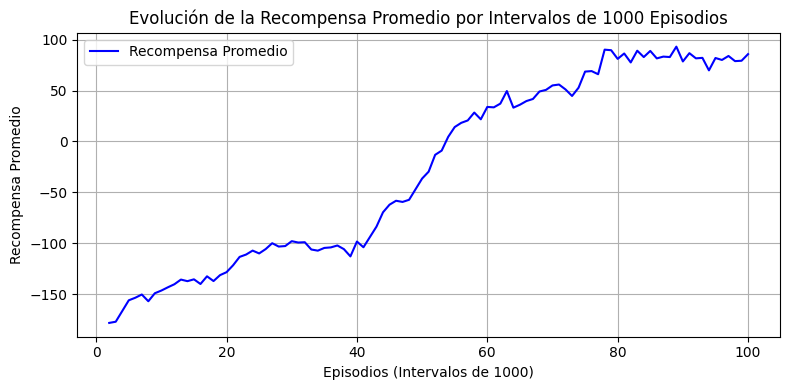

In [15]:
import matplotlib.pyplot as plt

# Datos de recompensa promedio a lo largo de los episodios
episodios_ajustados = list(range(1, 101))


# Crear la gráfica
plt.figure(figsize=(8,4))
plt.plot(episodios_ajustados, promedio_recompensa, label='Recompensa Promedio', color='blue')

# Añadir etiquetas y título
plt.xlabel('Episodios (Intervalos de 1000)')
plt.ylabel('Recompensa Promedio')
plt.title('Evolución de la Recompensa Promedio por Intervalos de 1000 Episodios')
plt.legend()
plt.grid(True)
plt.tight_layout()


# Mostrar la gráfica
plt.show()



### Fase inicial (Episodios 1 - 20.000):
En los primeros 20.000 episodios, el agente tiene un desempeño consistentemente bajo, con recompensas promedio que oscilan entre -176 y -122. Esto es típico al inicio del entrenamiento, cuando el agente está explorando y cometiendo errores mientras aprende las dinámicas del entorno. Aquí vemos que el valor de la recompensa promedio mejora lentamente, pero sigue siendo negativo.

### Fase de estabilización (Episodios 20.000 - 40.000):
Entre los episodios 20,000 y 40,000, el agente muestra una tendencia hacia la estabilización. La recompensa promedio continúa mejorando, y se aproxima a -100 en varios puntos, pero aún se registran caídas, como los episodios en torno a los 35,000, donde la recompensa promedio disminuye brevemente. Esto puede indicar que el agente sigue cometiendo errores significativos, pero empieza a aprender estrategias básicas.

### Mejora sostenida (Episodios 40.000 - 60.000):
A partir de los 40.000 episodios, se observa una mejora más pronunciada en la recompensa promedio. El agente pasa de recompensas alrededor de -100 a valores cercanos a 0 cuando se acerca a los 60.000. Esto sugiere que el agente ha comenzado a entender mejor cómo aterrizar con éxito en el entorno LunarLander. La recompensa promedio incluso llega a valores positivos por primera vez alrededor de los 57.000 episodios, lo que indica un progreso significativo en el aprendizaje.

### Fase de alto rendimiento (Episodios 60.000 - 100.000):
A partir de los 60.000 episodios, el agente experimenta un incremento continuo en su desempeño. Las recompensas promedio se mantienen en su mayoría positivas, llegando a valores entre 50 y 60 hacia el final del entrenamiento. Este periodo muestra que el agente ha alcanzado un nivel considerable de competencia, aunque sigue habiendo fluctuaciones, posiblemente debido a exploraciones que el agente realiza esporádicamente para optimizar su política de acciones.



## Análisis de casos (Éxitos y Fallos)

#### Funcion para reproducir un episodio individual de la prueba

In [16]:
# Función para reproducir un episodio específico
def reproducir_episodio(agente, episodio, semilla, max_iteraciones=500):
    entorno = gym.make('LunarLander-v2', render_mode='human').env
    entorno.reset(seed=semilla)
    iteraciones = 0
    termino = False
    truncado = False
    estado_anterior, info = entorno.reset(seed=semilla)
    while iteraciones < max_iteraciones and not termino and not truncado:
        accion = episodio[iteraciones][1]
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        entorno.render()
        estado_anterior = estado_siguiente
        iteraciones += 1
    entorno.close()

### Reproducir episodios exitosos y no exitosos de los casos de prueba

In [37]:
# Reproducir un episodio específico
episodio_especifico = 30  # Cambia este valor al episodio que quieras reproducir
if episodio_especifico < len(episodios_exitosos):
    reproducir_episodio(agente, episodios_exitosos[episodio_especifico], semillas_exitosas[episodio_especifico])
else:
    print(f"No hay suficientes episodios exitosos para reproducir el episodio {episodio_especifico}")

In [44]:
# Reproducir un episodio específico
episodio_especifico = 10  # Cambia este valor al episodio que quieras reproducir
if episodio_especifico < len(episodios_no_exitosos):
    reproducir_episodio(agente, episodios_no_exitosos[episodio_especifico], semillas_no_exitosas[episodio_especifico])
else:
    print(f"No hay suficientes episodios no exitosos para reproducir el episodio {episodio_especifico}")

### Episodios Exitosos y no exitosos

La indeterminación del entorno en el problema del Lunar Lander proviene de la discretización de los estados. Dado que un mismo estado discretizado puede llevar a diferentes resultados debido a pequeñas variaciones que no se capturan en la discretización, el comportamiento del agente no siempre es predecible. El agente ha logrado aprender y adaptarse de manera efectiva en un (porcentaje) de los 1,000 episodios de prueba.

#### Episodios Exitosos

En los casos exitosos, el agente ha demostrado un control eficiente del propulsor principal, asegurándose de que la nave nunca descienda a una velocidad demasiado alta. Este control es fundamental para permitir que el agente pueda ajustar su orientación horizontal hacia la zona de aterrizaje. Desde el inicio, el agente toma decisiones que mantienen un equilibrio entre el uso del propulsor principal y los propulsores laterales, lo que le permite encadenar acciones efectivas que lo llevan a una recompensa exitosa.

Un patrón clave en los episodios exitosos es que, al evitar el uso excesivo de los propulsores laterales en momentos inadecuados, el agente es capaz de mantener una trayectoria controlada hacia la meta. Esto es particularmente importante en las primeras etapas del episodio, donde las decisiones erróneas tienen un mayor impacto negativo en el aterrizaje. Al ejecutar correctamente los propulsores en los momentos críticos, el agente asegura un aterrizaje seguro y controlado.



#### Episodios No Exitosos

Uno de los principales problemas observados en los casos fallidos es que el agente es muy vulnerable durante la fase de aterrizaje. Si una de las patas de la nave se dobla o toca el suelo de manera incorrecta, el agente no puede recuperar el control, lo que conduce a una falla inmediata. Esta vulnerabilidad también se observa en su sensibilidad a la velocidad y el ángulo de inclinación. Aunque el agente llega muchas veces a una posición correcta para el aterrizaje, una decisión tardía o incorrecta de inclinarse hacia un lado debido a la velocidad provoca que pierda estabilidad y termine fuera de control.

Estos errores indican que el agente tiene dificultades para manejar situaciones críticas en los últimos momentos del aterrizaje, donde la precisión y el control fino son esenciales. Una pequeña desviación en velocidad o ángulo es suficiente para desestabilizar completamente el aterrizaje, sin oportunidad de recuperación.


#### Conclusiones sobre el Éxito y el Fracaso

Podemos concluir que el éxito de un episodio está altamente influenciado por la capacidad del agente para tomar decisiones acertadas durante todo el proceso, y no solo al principio. Aunque las decisiones iniciales son importantes, el mayor desafío se presenta al final del episodio, cuando el agente debe ser capaz de ajustar con precisión su velocidad y ángulo para lograr un aterrizaje exitoso.

El agente es particularmente sensible a las correcciones después de tomar una mala decisión, y su incapacidad para recuperarse adecuadamente de estas puede llevar rápidamente al fracaso. La limitación de no poder activar más de un propulsor a la vez y el uso de un espacio discretizado para las decisiones agrava este problema, haciendo que pequeñas desviaciones se tornen críticas.

La clave del éxito radica en que el agente logre recuperarse eficazmente ante situaciones desfavorables y ajuste de manera precisa sus movimientos en los momentos críticos, especialmente al acercarse al aterrizaje. Esto maximiza sus probabilidades de éxito, minimizando las penalizaciones.

## Limitantes del agente

### Capacidad del agente a tomar una única acción a la vez

En el entorno Lunar Lander, solo se permite realizar una acción a la vez, es decir, no tenemos la posibilidad de propulsarnos en más de una dirección a la vez, lo que podría estar produciendo la poca capacidad del agente a recuperarse luego de inclinarse por demás hacia un lado.

En este problema, esto no tendría solución ya que es parte del entorno establecido.

### Discretización de estados

Al discretizar un espacio de estados continuo (como la posición, velocidad o ángulo en Lunar Lander), se simplifican los valores en "bins" o rangos discretos, lo que implica que se pierde información importante. Dos estados que podrían ser distintos en el espacio continuo pueden terminar representados como el mismo estado discreto, lo que reduce la precisión del aprendizaje.

Además, a medida que aumenta el número de dimensiones (variables como posición, velocidad, ángulo, etc.), discretizar cada una puede llevar a un crecimiento exponencial del espacio de estados, donde el número de combinaciones posibles de estados se dispara, haciendo que el aprendizaje sea ineficiente y más difícil de escalar.

#### Posible mejora

En lugar de utilizar una tabla Q donde cada estado es discretizado, se pueden emplear otros métodos que nos permitan trabajar directamente con el espacio continuo, ya que pueden aproximar valores Q para cualquier estado en lugar de depender de estados discretizados fijos. Esto mejora la capacidad del agente para generalizar y aprender políticas más suaves en un espacio continuo.

### Escasez de retroalimentación inmediata

En Lunar Lander, la recompensa principal llega solo al final del episodio (aterrizaje exitoso o colisión). Esto dificulta que el agente aprenda qué acciones tempranas contribuyen a un aterrizaje exitoso.

#### Posible mejora

Se podría adaptar la funcion de recompensa del problema y agregar mayores recomensas por buenos movimientos al comienzo del episodio. Lo que tiene esto de contraparte es que estamos imponiendole al agente movimientos que nosotros creemos correctos y pueden no serlo.

### Conclusión

El desarrollo de este laboratorio con Q-learning en el entorno Lunar Lander nos permitió profundizar en el tema de aprendizaje por refuerzos. A través de la implementación de estrategias y las decisiones que tomamos, aprendimos la importancia de equilibrar la exploración y la explotación para optimizar el aprendizaje del agente.

El agente, aunque inicialmente carecía de información sobre el entorno, mejoró su capacidad de aterrizaje con el tiempo, alcanzando un 35% de aciertos en 1000 episodios. A lo largo del proceso, fue clave entender cómo el entorno no determinista afecta el rendimiento y cómo las malas decisiones del agente tienen un impacto duradero en los resultados.

Este ejercicio destacó la importancia de ajustar las estrategias de aprendizaje para adaptarse a las particularidades del problema, como la naturaleza continua del espacio de estados.

En conclusión creemos haber obtenido un buen resultado a pesar de la complejidad del problema y las decisiones tomadas para simplificarlo como por ejemplo, la discretización de los estados. Además, entendimos la influencia de los parámetros elegidos sobre los resultados y cómo debemos adaptar estos al problema específico que queremos resolver.